In [174]:
from gurobipy import *
import numpy as np
import pandas as pd



In [175]:
Data = pd.read_csv('/Users/weiliang/Desktop/project/Veri_1.in',header = None)


Data.columns= ['ID','OrderID','Hour','BitType','Quantity','price','Duration','LinkID']


Data.head()


,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,11,1,1,S,-35279.0,0.00,1,NaN
1,11,2,1,S,-39053.0,1.05,1,NaN
2,11,3,1,S,-40828.0,2.27,1,NaN
3,11,4,1,S,-42718.0,4.08,1,NaN
4,11,5,1,S,-44405.0,6.14,1,NaN


In [176]:
Index = []
for i in range(len(Data)):
    if Data['BitType'][i]=='S':
        Index.append(i)
Data_H = Data.iloc[Index]
Data_H = Data_H.reset_index(drop=True)

# Data_H.to_csv('/Users/weiliang/Desktop/project/Data_H.csv')

Data_H.head()


,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,11,1,1,S,-35279.0,0.00,1,NaN
1,11,2,1,S,-39053.0,1.05,1,NaN
2,11,3,1,S,-40828.0,2.27,1,NaN
3,11,4,1,S,-42718.0,4.08,1,NaN
4,11,5,1,S,-44405.0,6.14,1,NaN


In [177]:
Index_D = []
Index_S = []
for i in range(len(Data_H)):
    if Data_H['Quantity'][i]<0:
        Index_D.append(i)
    else:
        Index_S.append(i)

Data_H_D = Data_H.iloc[Index_S]
Data_H_D = Data_H_D.reset_index(drop=True)
Data_H_S = Data_H.iloc[Index_D]
Data_H_S = Data_H_S.reset_index(drop=True)


In [178]:
Data_H_SP = Data_H_S
Hour = []
# for i in range(len(Data_H_SP)):
    
#     Data_H_SP['Quantity'][i] = Data_H_S['Quantity'][i]
Data_H_SP['Quantity']=Data_H_SP['Quantity'].abs()
Data_H_SP



,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,11,1,1,S,35279.0,0.00,1,NaN
1,11,2,1,S,39053.0,1.05,1,NaN
2,11,3,1,S,40828.0,2.27,1,NaN
3,11,4,1,S,42718.0,4.08,1,NaN
4,11,5,1,S,44405.0,6.14,1,NaN
...,...,...,...,...,...,...,...,...
23995,241,996,24,S,199775.0,1991.26,1,NaN
23996,241,997,24,S,199819.0,1992.96,1,NaN
23997,241,998,24,S,199880.0,1995.33,1,NaN
23998,241,999,24,S,199946.0,1997.90,1,NaN


In [179]:

def Hour_Index(df):
    Index = []
    S = 0
    End = 0
    Hour_list = np.arange(1,25)
    for i in range(24):
        for j in range(len(df)):
            if df['Hour'][j]==Hour_list[i]:
                End = j
        Index.append((S,End))
        S = End+1
    return Index
            
                




In [180]:
HIndex_S=Hour_Index(Data_H_SP)
HIndex_D=Hour_Index(Data_H_D)
def find_largest(IND):
    Res = IND[0][1]-IND[0][1]
    for i in range(len(IND)):
        if (IND[i][1]-IND[i][0])>=Res:
            Res = (IND[i][1]-IND[i][0])
    return Res

find_largest(HIndex_D)

999

In [181]:
# Data_H_D.to_csv('/Users/weiliang/Desktop/project/Data_H_D.csv')
# Data_H_SP.to_csv('/Users/weiliang/Desktop/project/Data_H_SP.csv')

In [182]:
def Pair(postion,Hour,DF,QP):
    
    if QP == 'DQ':
        DF=DF.iloc[HIndex_D[Hour-1][0]:HIndex_D[Hour-1][1]+1]
        return [DF['Quantity'][postion-1+HIndex_D[Hour-1][0]],DF['Quantity'][postion+HIndex_D[Hour-1][0]]]
    if QP == 'SQ':
        DF=DF.iloc[HIndex_S[Hour-1][0]:HIndex_S[Hour-1][1]+1]
        return [DF['Quantity'][postion-1+HIndex_S[Hour-1][0]],DF['Quantity'][postion+HIndex_S[Hour-1][0]]]
    if QP == 'DP':
        DF=DF.iloc[HIndex_D[Hour-1][0]:HIndex_D[Hour-1][1]+1]
        return [DF['price'][postion-1+HIndex_D[Hour-1][0]],DF['price'][postion+HIndex_D[Hour-1][0]]]
    else:
        DF=DF.iloc[HIndex_S[Hour-1][0]:HIndex_S[Hour-1][1]+1]
        return [DF['price'][postion-1+HIndex_S[Hour-1][0]],DF['price'][postion+HIndex_S[Hour-1][0]]]


In [191]:
E = Model("Energy")
E.params.NonConvex =2
E.update()
J = np.arange(1,find_largest(HIndex_D)+1)
K = np.arange(1,find_largest(HIndex_S)+1)
H = np.arange(1,25)


Set parameter NonConvex to value 2


In [192]:


xD = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.CONTINUOUS, name='xD')
xS = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.CONTINUOUS, name='xS')
w_D = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.CONTINUOUS,name ='W_D')
w_S = E.addVars(H,J,ub=1,lb=0,  vtype=GRB.CONTINUOUS,name ='W_S')




E.setObjective(sum(0.5*(2*Pair(j,h,Data_H_D,'DP')[0]+xD[h,j]*(Pair(j,h,Data_H_D,'DP')[1]-Pair(j,h,Data_H_D,'DP')[0]))*xD[h,j]*(Pair(j,h,Data_H_D,'DQ')[1]-Pair(j,h,Data_H_D,'DQ')[0])for j in J for h in H)
                -sum(0.5*(2*Pair(j,h,Data_H_SP,'SP')[0]+xS[h,j]*(Pair(j,h,Data_H_SP,'SP')[1]-Pair(j,h,Data_H_SP,'SP')[0]))*xS[h,j]*(Pair(j,h,Data_H_SP,'SQ')[1]-Pair(j,h,Data_H_SP,'SQ')[0])for j in J for h in H)
,GRB.MAXIMIZE)



E.addConstr(-sum((Pair(j,h,Data_H_D,'DQ')[1]-Pair(j,h,Data_H_D,'DQ')[0])*xD[h,j] for j in J for h in H) +sum((Pair(j,h,Data_H_SP,'SQ')[1]-Pair(j,h,Data_H_SP,'SQ')[0])*xS[h,j] for j in J for h in H) -sum(Pair(1,h,Data_H_D,'DQ')[0] for h in H)+sum(Pair(1,h,Data_H_SP,'SQ')[0] for h in H) == 0)
# Demand
E.addConstrs(w_D[h,1]<=xD[h,1] for h in H)
E.addConstrs(xD[h,1] <=1 for h in H)
E.addConstrs(w_D[h,j]<=xD[h,j] for j in range(2,find_largest(HIndex_D)+1) for h in H)
E.addConstrs(xD[h,j]<=w_D[h,j-1] for j in range(2,find_largest(HIndex_D)+1) for h in H)
# Supply
E.addConstrs(w_S[h,1]<=xS[h,1] for h in H)
E.addConstrs(xS[h,1] <=1 for h in H)
E.addConstrs(w_S[h,j]<=xS[h,j] for j in range(2,find_largest(HIndex_S)+1) for h in H)
E.addConstrs(xS[h,j]<=w_S[h,j-1] for j in range(2,find_largest(HIndex_S)+1) for h in H)




E.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 95905 rows, 95904 columns and 239712 nonzeros
Model fingerprint: 0xe7b2cb99
Model has 47952 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 8e+03]
  Objective range  [1e+02, 4e+05]
  QObjective range [2e-02, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+06]
Presolve removed 48000 rows and 47952 columns
Presolve time: 0.17s
Presolved: 47905 rows, 47952 columns, 143760 nonzeros
Presolved model has 47952 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.576e+04
 Factor NZ  : 8.089e+05 (roughly 45 MB of memory)
 Factor Ops : 1.703e+07 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.38720267e+11  2.73299975e+10  

In [193]:
Res_D = []
Res_S = []
for i in range(1,1000):

    Res_D.append(E.getAttr('x',xS)[(2,i)])
    Res_S.append(E.getAttr('x',xS)[(2,i)])



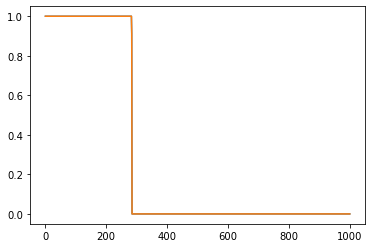

In [194]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,1000),Res_S)
plt.plot(np.arange(1,1000),Res_D)

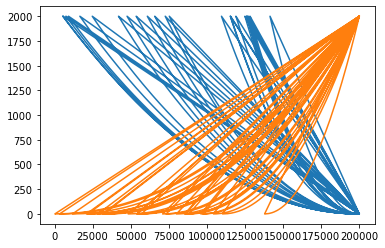

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Data_H_D['Quantity'],Data_H_D['price'])
plt.plot(Data_H_SP['Quantity'],Data_H_SP['price'])